# Calculate network routes between CHTS-derived origins and destinations

IGNORING FREEWAYS + USING IGRAPH (brings simulation time down from ~10 hours to ~1.5 hours)

In [1]:
import igraph as ig
import math
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from scipy.stats import ttest_ind

np.random.seed(0)
simulate_all_trips = True

## Load network and ODs

In [2]:
%%time
# load the networks
G_dir = ox.load_graphml('data/network/sf-directed-no-fwy.graphml', folder='.')
G_undir = ox.load_graphml('data/network/sf-undirected-no-fwy.graphml', folder='.')

Wall time: 3.44 s


In [3]:
print(nx.is_strongly_connected(G_dir))
print(nx.is_strongly_connected(G_undir))

True
True


In [4]:
# load the origin-destination node pairs from CHTS
od_dir = pd.read_csv('data/od-directed-no-fwy.csv')
od_undir = pd.read_csv('data/od-undirected-no-fwy.csv')

# confirm the origins and destinations match between the two datasets
# (so we're simulating the same set of trips on each graph)
assert (od_dir['orig']==od_undir['orig']).sum() == len(od_dir) == len(od_undir)
assert (od_dir['dest']==od_undir['dest']).sum() == len(od_dir) == len(od_undir)
print(len(od_dir))

1594


## How many trips to simulate

In [5]:
# there are 1,133,333 daily trips that being/end in SF
if simulate_all_trips:
    total_daily_trips = 1133333
    multiplier = total_daily_trips / len(od_dir)
    multiplier = math.ceil(multiplier)
else:
    multiplier = 1
multiplier

711

In [6]:
od_dir = pd.concat([od_dir]*multiplier, ignore_index=True)
len(od_dir)

1133334

In [7]:
od_undir = pd.concat([od_undir]*multiplier, ignore_index=True)
len(od_dir)

1133334

## Convert networkx graphs to igraph

In [8]:
weight = 'length'

G_dir = nx.relabel.convert_node_labels_to_integers(G_dir)
G_dir_nodeid_to_osmid = {data['osmid']:nodeid for nodeid, data in G_dir.nodes().items()}

G_undir = nx.relabel.convert_node_labels_to_integers(G_undir)
G_undir_nodeid_to_osmid = {data['osmid']:nodeid for nodeid, data in G_undir.nodes().items()}

In [9]:
%%time
# convert directed networkx graph to igraph
G_dir_ig = ig.Graph(directed=True)
G_dir_ig.add_vertices(list(G_dir.nodes()))
G_dir_ig.add_edges(list(G_dir.edges()))
G_dir_ig.vs['osmid'] = list(nx.get_node_attributes(G_dir, 'osmid').values())
G_dir_ig.es[weight] = list(nx.get_edge_attributes(G_dir, weight).values())

assert len(G_dir.nodes()) == G_dir_ig.vcount()
assert len(G_dir.edges()) == G_dir_ig.ecount()

Wall time: 58 ms


In [10]:
%%time
# convert undirected networkx graph to igraph
G_undir_ig = ig.Graph(directed=False)
G_undir_ig.add_vertices(list(G_undir.nodes()))
G_undir_ig.add_edges(list(G_undir.edges()))
G_undir_ig.vs['osmid'] = list(nx.get_node_attributes(G_undir, 'osmid').values())
G_undir_ig.es[weight] = list(nx.get_edge_attributes(G_undir, weight).values())

assert len(G_undir.nodes()) == G_undir_ig.vcount()
assert len(G_undir.edges()) == G_undir_ig.ecount()

Wall time: 62 ms


## Calculate routes between origins and destinations

#### First, look at topological graph distance (number of edges/blocks traversed)

In [11]:
# calculate shortest path topological distance (edges) between rows' origin and destination nodes
def network_distance(row, G_ig, nodeid_to_osmid, weight=None):
    try:
        source = nodeid_to_osmid[row['orig']]
        target = nodeid_to_osmid[row['dest']]
        return G_ig.shortest_paths(source=source, target=target, weights=weight)[0][0]
    except:
        return np.nan

In [12]:
%%time
# for the real-world directed graph
od_dir['network_distance_e'] = od_dir.apply(network_distance, axis=1, G_ig=G_dir_ig, nodeid_to_osmid=G_dir_nodeid_to_osmid)

Wall time: 20min 33s


In [13]:
%%time
# for the bidirectional undirected graph
od_undir['network_distance_e'] = od_undir.apply(network_distance, axis=1, G_ig=G_undir_ig, nodeid_to_osmid=G_undir_nodeid_to_osmid)

Wall time: 23min 25s


In [14]:
blocks_dir = od_dir['network_distance_e'].replace([np.inf, -np.inf], np.nan).dropna()
blocks_dir.describe()

count    1.133334e+06
mean     3.897679e+01
std      2.092597e+01
min      0.000000e+00
25%      2.200000e+01
50%      3.800000e+01
75%      5.300000e+01
max      1.070000e+02
Name: network_distance_e, dtype: float64

In [15]:
blocks_undir = od_undir['network_distance_e'].replace([np.inf, -np.inf], np.nan).dropna()
blocks_undir.describe()

count    1.133334e+06
mean     3.721706e+01
std      1.993647e+01
min      0.000000e+00
25%      2.200000e+01
50%      3.600000e+01
75%      5.100000e+01
max      1.040000e+02
Name: network_distance_e, dtype: float64

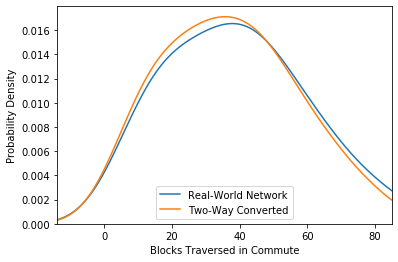

In [16]:
bw = 0.4
lw = 1.5
ax = (blocks_dir).plot.kde(label='Real-World Network', lw=lw, bw_method=bw)
ax = (blocks_undir).plot.kde(ax=ax, label='Two-Way Converted', lw=lw, bw_method=bw)
ax.set_ylim(bottom=0)
ax.set_xlim(left=-14, right=85)
ax.set_xlabel('Blocks Traversed in Commute')
ax.set_ylabel('Probability Density')
plt.legend()
plt.show()

In [17]:
# are the average blocks-traveled per trip significantly different?
a = blocks_dir
b = blocks_undir
diff = a.mean() - b.mean()
t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit', )

# convert from two-tailed to one-tailed p-value, because one-way network could never be shorter than two-way
p_value = p_value / 2
print('n={:}, δ={:0.2f}, t={:0.2f}, p={:0.4f}'.format(len(a), diff, t_statistic, p_value))

n=1133334, δ=1.76, t=64.82, p=0.0000


#### Second, look at metric distance (meters traveled)

In [18]:
%%time
# for the real-world directed graph
od_dir['network_distance_m'] = od_dir.apply(network_distance, axis=1, G_ig=G_dir_ig, nodeid_to_osmid=G_dir_nodeid_to_osmid, weight='length')

Wall time: 27min 48s


In [19]:
%%time
# for the bidirectional undirected graph
od_undir['network_distance_m'] = od_undir.apply(network_distance, axis=1, G_ig=G_undir_ig, nodeid_to_osmid=G_undir_nodeid_to_osmid, weight='length')

Wall time: 33min 26s


In [20]:
meters_dir = od_dir['network_distance_m'].replace([np.inf, -np.inf], np.nan).dropna()
meters_dir.describe()

count    1.133334e+06
mean     4.943137e+03
std      2.859271e+03
min      0.000000e+00
25%      2.736591e+03
50%      4.684213e+03
75%      6.758932e+03
max      1.358906e+04
Name: network_distance_m, dtype: float64

In [21]:
meters_undir = od_undir['network_distance_m'].replace([np.inf, -np.inf], np.nan).dropna()
meters_undir.describe()

count    1.133334e+06
mean     4.871542e+03
std      2.841013e+03
min      0.000000e+00
25%      2.676304e+03
50%      4.606219e+03
75%      6.695332e+03
max      1.339464e+04
Name: network_distance_m, dtype: float64

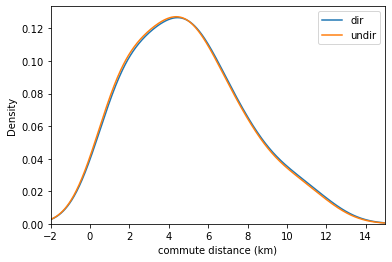

In [22]:
ax = (meters_dir/1000).plot.kde(label='dir', bw_method=bw)
ax = (meters_undir/1000).plot.kde(ax=ax, label='undir', bw_method=bw)
ax.set_ylim(bottom=0)
ax.set_xlim(left=-2, right=15)
ax.set_xlabel('commute distance (km)')
plt.legend()
plt.show()

In [23]:
# are the average distances (m) traveled per trip significantly different?
a = meters_dir
b = meters_undir
diff = a.mean() - b.mean()
t_statistic, p_value = ttest_ind(a=a, b=b, equal_var=False, nan_policy='omit', )

# convert from two-tailed to one-tailed p-value, because one-way network could never be shorter than two-way
p_value = p_value / 2
print('n={:}, δ={:0.2f}, t={:0.2f}, p={:0.4f}'.format(len(a), diff, t_statistic, p_value))

n=1133334, δ=71.59, t=18.91, p=0.0000


In [24]:
a.mean() / b.mean()

1.0146965634044165

In [25]:
difference = a - b
difference.describe()

count    1.133334e+06
mean     7.159493e+01
std      1.026974e+02
min     -1.818989e-12
25%      1.569000e+00
50%      2.777800e+01
75%      1.015620e+02
max      1.096134e+03
Name: network_distance_m, dtype: float64

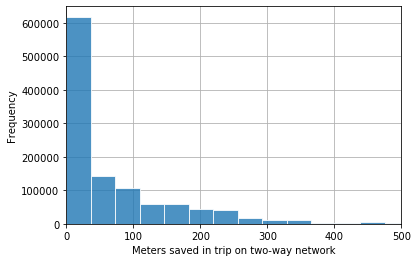

In [26]:
ax = difference.plot.hist(bins=30, ec='w', alpha=0.8, zorder=2)
ax.set_xlim(left=0, right=500)
ax.set_ylim(bottom=0)
ax.grid(True)
ax.set_xlabel('Meters saved in trip on two-way network')
plt.show()

## Surplus VKT and fuel consumption 

In [75]:
# converters
miles_to_km = 1.60934 #factor to convert miles to km
mpg_to_kpl = 0.425144 #factor to convert fuel economy miles per gallon to km per liter
lb_per_gal_to_kg_per_liter = 0.119826 #factor to convert emissions from pounds per gallon to kg per liter

#### Excess VKT per day and per year

What is the daily VKT in San Francisco? There are competing figures out there.

**SFCTA**'s TNCs Today report appears to estimate VMT for trips that both begin and end within the city: "Ride-hail vehicles drive approximately 570,000 vehicle miles within San Francisco on a typical weekday. This accounts for 20 percent of all local daily vehicle miles traveled" from https://www.sfcta.org/tncstoday

**CalTrans**'s 2017 Public Roads Data report appears to estimate all the VMT that occurs on the city's (county's) streets, even if the trip is just passing through SF (9,648,730 miles/day). https://dot.ca.gov/-/media/dot-media/programs/research-innovation-system-information/documents/prd2017.pdf

Finally, SFCTA estimates 1,133,333 occur each day entirely within SF. "On a typical weekday, ride-hail vehicles make more than 170,000 vehicle trips within San Francisco, approximately 12 times the number of taxi trips, representing 15 percent of all intra-San Francisco vehicle trips." from https://www.sfcta.org/tncstoday

In [76]:
#sf_daily_vmt = 9648730    #CalTrans estimate (all trips through SF)
sf_daily_vmt = 570000 * 5 #SFCTA estimate (only trips entirely within SF)
sf_daily_vkt = int(sf_daily_vmt * miles_to_km)
sf_daily_vkt

4586619

In [77]:
# estimate surplus VKT per day
surplus_vkt_daily = int(sf_daily_vkt - (sf_daily_vkt / (a.mean() / b.mean())))
surplus_vkt_daily

66431

In [78]:
# estimate surplus VKT per year
surplus_vkt_annual = int(surplus_vkt_daily * 365)
surplus_vkt_annual

24247315

#### Excess Fuel Consumption and GHG Emission

Average US fuel economy is 24.7 miles/gallon: https://www.reuters.com/article/us-autos-emissions/u-s-vehicle-fuel-economy-rises-to-record-24-7-mpg-epa-idUSKBN1F02BX

Burning 1 gallon of gasoline releases 20 lbs of CO2: https://www.fueleconomy.gov/feg/contentIncludes/co2_inc.htm

In [72]:
# what is the average US fuel economy in km/liter?
fuel_econ_mpg = 24.7 #per reuters
fuel_econ_kpl = fuel_econ_mpg * mpg_to_kpl
fuel_econ_kpl

10.5010568

In [73]:
# how many surplus liters of fuel does this waste per year?
surplus_fuel_liters = surplus_vkt_annual / fuel_econ_kpl
int(surplus_fuel_liters)

2309035

In [74]:
# how many kg of CO2 are released from combusting 1 liter of gasoline?
co2_lbs_per_gal = 20 #per fueleconomy.gov
co2_kg_per_liter = co2_lbs_per_gal * lb_per_gal_to_kg_per_liter
co2_kg_per_liter

2.39652

In [71]:
# how many excess kg of CO2 are released each year?
int(surplus_fuel_liters * co2_kg_per_liter)

5533650

## Save to disk

In [35]:
left = od_dir
right = od_undir[['network_distance_e', 'network_distance_m']]
df = pd.merge(left, right, left_index=True, right_index=True, suffixes=('_dir', '_undir'))
df.head()

,SAMPN,PERNO,orig,dest,network_distance_e_dir,network_distance_m_dir,network_distance_e_undir,network_distance_m_undir
0,1033944,1,65335448,65303721,82,10454.083,77,10251.384
1,1049908,1,65334137,1723738893,13,1584.919,12,1468.412
2,1051388,2,65298349,65303529,45,5345.391,42,5025.408
3,1051795,1,65294011,65352454,55,8891.224,53,8462.170
4,1069723,1,65301529,65329980,28,3881.144,28,3880.040


In [36]:
# save to disk
df.to_csv('data/od_distances-no-fwy-igraph.csv', index=False, encoding='utf-8')